<img src="https://www.iwco.co/static/images/iwco-square-logo.webp" width="200" title="hover text" style="border-radius: 50%">
# ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Laboratorio Datalakes

Laboratorio de Datalakes sobre Databricks

## The Data

The data used is public data from Lending Club. It includes all funded loans from 2012 to 2017. Each loan includes applicant information provided by the applicant as well as the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. For a full view of the data please view the data dictionary available [here](https://resources.lendingclub.com/LCDataDictionary.xlsx).


![Loan_Data](https://preview.ibb.co/d3tQ4R/Screen_Shot_2018_02_02_at_11_21_51_PM.png)

https://www.kaggle.com/wendykan/lending-club-loan-data

## ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Delta Lake

Optimization Layer a top blob storage for Reliability (i.e. ACID compliance) and Low Latency of Streaming + Batch data pipelines.

## Import Data and create pre-Delta Lake Table
* This will create a lot of small Parquet files emulating the typical small file problem that occurs with streaming or highly transactional data

In [0]:
%pip install mlflow yellowbrick

In [0]:
%fs ls /databricks-datasets/samples/lending_club/parquet/

path,name,size
dbfs:/databricks-datasets/samples/lending_club/parquet/_SUCCESS,_SUCCESS,0
dbfs:/databricks-datasets/samples/lending_club/parquet/_committed_4376965328215018897,_committed_4376965328215018897,514
dbfs:/databricks-datasets/samples/lending_club/parquet/_started_4376965328215018897,_started_4376965328215018897,0
dbfs:/databricks-datasets/samples/lending_club/parquet/part-00000-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-443-c000.snappy.parquet,part-00000-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-443-c000.snappy.parquet,72106652
dbfs:/databricks-datasets/samples/lending_club/parquet/part-00001-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-444-c000.snappy.parquet,part-00001-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-444-c000.snappy.parquet,57676765
dbfs:/databricks-datasets/samples/lending_club/parquet/part-00002-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-445-c000.snappy.parquet,part-00002-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-445-c000.snappy.parquet,43307289
dbfs:/databricks-datasets/samples/lending_club/parquet/part-00003-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-446-c000.snappy.parquet,part-00003-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-446-c000.snappy.parquet,21780130
dbfs:/databricks-datasets/samples/lending_club/parquet/part-00004-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-447-c000.snappy.parquet,part-00004-tid-4376965328215018897-67dfb805-a14c-42f6-99f0-1a6608ac4723-447-c000.snappy.parquet,60919


In [0]:
llave = 'rhyu9sXVdYCIBbAW7VgBF+/hNcq3iJNAVrMnVGikn+ZaRBdyHLt6NBf9SKhY7YTgHq2tQV3APwhSN33NhKZhww=='
cuenta = 'iwco'
contenedor = 'public'

try:
  dbutils.fs.mount(
    source = f"wasbs://{contenedor}@{cuenta}.blob.core.windows.net",
    mount_point = f"/mnt/{contenedor}",
    extra_configs = {f"fs.azure.account.key.{cuenta}.blob.core.windows.net":f"{llave}"})
except:
  pass

In [0]:
dbutils.fs.cp ("dbfs:/databricks-datasets/samples/lending_club/parquet", f"/mnt/{contenedor}/lending_club/", True) 

Out[3]: True

In [0]:
# -----------------------------------------------
# Uncomment and run if this folder does not exist
# -----------------------------------------------
# Configure location of loanstats_2012_2017.parquet
lspq_path = f"/mnt/{contenedor}/lending_club/"

# Read loanstats_2012_2017.parquet
data = spark.read.parquet(lspq_path)

# Reduce the amount of data (to run on DBCE)
(loan_stats, loan_stats_rest) = data.randomSplit([0.01, 0.99], seed=123)

# Select only the columns needed
loan_stats = loan_stats.select("addr_state", "loan_status")

# Create loan by state
loan_by_state = loan_stats.groupBy("addr_state").count()

# Create table
loan_by_state.createOrReplaceTempView("loan_by_state")

# Display loans by state
display(loan_by_state)

addr_state,count
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


## ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Easily Convert Parquet to Delta Lake format
With Delta Lake, you can easily transform your Parquet data into Delta Lake format.

In [0]:
# Configure Delta Lake Silver Path
DELTALAKE_SILVER_PATH = f"/mnt/{contenedor}/lending_club_delta/"

# Remove folder if it exists
dbutils.fs.rm(DELTALAKE_SILVER_PATH, recurse=True)

Out[5]: False

In [0]:
%sql 
-- Current example is creating a new table instead of in-place import so will need to change this code
DROP TABLE IF EXISTS loan_by_state_delta;

CREATE TABLE loan_by_state_delta
USING delta
LOCATION '/mnt/public/lending_club_delta/'
AS SELECT * FROM loan_by_state;

-- View Delta Lake table
SELECT * FROM loan_by_state_delta

addr_state,count
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


In [0]:
%sql 
DESCRIBE DETAIL delta.`/mnt/public/lending_club_delta/`

format,id,name,description,location,createdAt,lastModified,partitionColumns,numFiles,sizeInBytes,properties,minReaderVersion,minWriterVersion
delta,0e1bd61a-114a-4184-a2f6-a926943c6fc0,null,null,dbfs:/mnt/public/lending_club_delta,2022-01-27T21:39:49.103+0000,2022-01-27T21:40:02.000+0000,List(),1,1188,Map(),1,2


## Stop the notebook before the streaming cell, in case of a "run all"

In [0]:
dbutils.notebook.exit("stop") 

stop

In [0]:
%fs ls /mnt/public/lending_club_delta/_delta_log/

path,name,size
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000000.crc,00000000000000000000.crc,89
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000000.json,00000000000000000000.json,1324
dbfs:/mnt/public/lending_club_delta/_delta_log/__tmp_path_dir/,__tmp_path_dir/,0


## ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Unified Batch and Streaming Source and Sink

These cells showcase streaming and batch concurrent queries (inserts and reads)
* This notebook will run an `INSERT` every 10s against our `loan_stats_delta` table
* We will run two streaming queries concurrently against this data
* Note, you can also use `writeStream` but this version is easier to run in DBCE

In [0]:
# Read the insertion of data
loan_by_state_readStream = spark.readStream.format("delta").load(DELTALAKE_SILVER_PATH)
loan_by_state_readStream.createOrReplaceTempView("loan_by_state_readStream")

In [0]:
%sql
select addr_state, sum(`count`) as loans from loan_by_state_readStream group by addr_state

addr_state,loans
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
WY,26


**Wait** until the stream is up and running before executing the code below

In [0]:
import time
i = 1
while i <= 6:
  # Execute Insert statement
  insert_sql = "INSERT INTO loan_by_state_delta VALUES ('IA', 450)"
  spark.sql(insert_sql)
  print('loan_by_state_delta: inserted new row of data, loop: [%s]' % i)
    
  # Loop through
  i = i + 1
  time.sleep(5)

loan_by_state_delta: inserted new row of data, loop: [1]
loan_by_state_delta: inserted new row of data, loop: [2]
loan_by_state_delta: inserted new row of data, loop: [3]
loan_by_state_delta: inserted new row of data, loop: [4]
loan_by_state_delta: inserted new row of data, loop: [5]
loan_by_state_delta: inserted new row of data, loop: [6]

In [0]:
%fs ls /mnt/public/lending_club_delta/_delta_log/

path,name,size
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000000.crc,00000000000000000000.crc,89
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000000.json,00000000000000000000.json,1324
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000001.crc,00000000000000000001.crc,89
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000001.json,00000000000000000001.json,843
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000002.crc,00000000000000000002.crc,89
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000002.json,00000000000000000002.json,843
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000003.crc,00000000000000000003.crc,89
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000003.json,00000000000000000003.json,843
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000004.crc,00000000000000000004.crc,89
dbfs:/mnt/public/lending_club_delta/_delta_log/00000000000000000004.json,00000000000000000004.json,843


**Note**: Once the previous cell is finished and the state of Iowa is fully populated in the map (in cell 14), click *Cancel* in Cell 14 to stop the `readStream`.

Let's review our current set of loans using our map visualization.

In [0]:
%sql
-- Review current loans within the `loan_by_state_delta` Delta Lake table
select addr_state, sum(`count`) as loans from loan_by_state_delta group by addr_state

addr_state,loans
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


Observe that the Iowa (middle state) has the largest number of loans due to the recent stream of data.  Note that the original `loan_by_state_delta` table is updated as we're reading `loan_by_state_readStream`.

##![Delta Lake Logo Tiny](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Full DML Support

**Note**: Full DML Support is a feature that will be coming soon to Delta Lake; the preview is currently available in Databricks.

Delta Lake supports standard DML including UPDATE, DELETE and MERGE INTO providing developers more controls to manage their big datasets.

Let's start by creating a traditional Parquet table

In [0]:
# Load new DataFrame based on current Delta table
lbs_df = sql("select * from loan_by_state_delta")

# Save DataFrame to Parquet
lbs_df.write.mode("overwrite").parquet(f"/mnt/{contenedor}/tmp/lending_club_delta/")

# Create new table on this parquet data
spark.sql("drop table if exists loan_by_state_pq")
spark.sql(f"create table loan_by_state_pq using parquet as select * from parquet.`/mnt/{contenedor}/tmp/lending_club_delta/`")

# Review data
display(sql("select * from loan_by_state_pq"))

addr_state,count
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


###![Delta Lake Logo Tiny](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) DELETE Support

The data was originally supposed to be assigned to `WA` state, so let's `DELETE` those values assigned to `IA`

In [0]:
%sql
-- Attempting to run `DELETE` on the Parquet table
DELETE FROM loan_by_state_pq WHERE addr_state = 'IA'

com.databricks.backend.common.rpc.DatabricksExceptions$SQLExecutionException: java.lang.AssertionError: assertion failed: No plan for DeleteFromTable (addr_state#8783 = IA)
+- Relation[addr_state#8783,count#8784L] parquet

	at scala.Predef$.assert(Predef.scala:223)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:100)
	at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:75)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$4(QueryPlanner.scala:85)
	at scala.collection.TraversableOnce.$anonfun$foldLeft$1(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.$anonfun$foldLeft$1$adapted(TraversableOnce.scala:162)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:162)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:160)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1429)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.$anonfun$plan$3(QueryPlanner.scala:82)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:484)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:490)
	at org.apache.spark.sql.catalyst.planning.QueryPlanner.plan(QueryPlanner.scala:100)
	at org.apache.spark.sql.execution.SparkStrategies.plan(SparkStrategies.scala:75)
	at org.apache.spark.sql.execution.QueryExecution$.createSparkPlan(QueryExecution.scala:493)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$sparkPlan$1(QueryExecution.scala:129)
	at com.databricks.spark.util.FrameProfiler$.record(FrameProfiler.scala:80)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:134)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:180)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:854)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:180)
	at org.apache.spark.sql.execution.QueryExecution.sparkPlan$lzycompute(QueryExecution.scala:129)
	at org.apache.spark.sql.execution.QueryExecution.sparkPlan(QueryExecution.scala:122)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executedPlan$1(QueryExecution.scala:141)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:854)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan$lzycompute(QueryExecution.scala:141)
	at org.apache.spark.sql.execution.QueryExecution.executedPlan(QueryExecution.scala:136)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$simpleString$2(QueryExecution.scala:199)
	at org.apache.spark.sql.execution.ExplainUtils$.processPlan(ExplainUtils.scala:115)
	at org.apache.spark.sql.execution.QueryExecution.simpleString(QueryExecution.scala:199)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$explainString(QueryExecution.scala:260)
	at org.apache.spark.sql.execution.QueryExecution.explainStringLocal(QueryExecution.scala:226)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withCustomExecutionEnv$5(SQLExecution.scala:123)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:273)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withCustomExecutionEnv$1(SQLExecution.scala:104)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:854)
	at org.apache.spark.sql.execution.SQLExecution$.withCustomExecutionEnv(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:223)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3823)
	at org.apache.spark.sql.Dataset. (Dataset.scala:235)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$2(Dataset.scala:104)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.sc

**Note**: This command fails because the `DELETE` statements are not supported in Parquet, but are supported in Delta Lake.

In [0]:
%sql
-- Running `DELETE` on the Delta Lake table
DELETE FROM loan_by_state_delta WHERE addr_state = 'IA'

num_affected_rows
6


In [0]:
%sql
-- Review current loans within the `loan_by_state_delta` Delta Lake table
select addr_state, sum(`count`) as loans from loan_by_state_delta group by addr_state

addr_state,loans
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


###![Delta Lake Logo Tiny](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) UPDATE Support
The data was originally supposed to be assigned to `WA` state, so let's `UPDATE` those values

In [0]:
%sql
-- Attempting to run `UPDATE` on the Parquet table
UPDATE loan_by_state_pq SET `count` = 2700 WHERE addr_state = 'WA'

com.databricks.backend.common.rpc.DatabricksExceptions$SQLExecutionException: org.apache.spark.sql.AnalysisException: UPDATE destination only supports Delta sources.
Some(Relation[addr_state#8783,count#8784L] parquet
)
	at com.databricks.sql.transaction.tahoe.DeltaErrors$.notADeltaSourceException(DeltaErrors.scala:429)
	at com.databricks.sql.transaction.tahoe.DeltaAnalysis$$anonfun$apply$1.applyOrElse(DeltaAnalysis.scala:254)
	at com.databricks.sql.transaction.tahoe.DeltaAnalysis$$anonfun$apply$1.applyOrElse(DeltaAnalysis.scala:74)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$2(AnalysisHelper.scala:172)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsDownWithPruning$1(AnalysisHelper.scala:172)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:340)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning(AnalysisHelper.scala:170)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDownWithPruning$(AnalysisHelper.scala:166)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDownWithPruning(LogicalPlan.scala:29)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDown(AnalysisHelper.scala:162)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsDown$(AnalysisHelper.scala:161)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsDown(LogicalPlan.scala:29)
	at com.databricks.sql.transaction.tahoe.DeltaAnalysis.apply(DeltaAnalysis.scala:74)
	at com.databricks.sql.transaction.tahoe.DeltaAnalysis.apply(DeltaAnalysis.scala:67)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$3(RuleExecutor.scala:221)
	at com.databricks.spark.util.FrameProfiler$.record(FrameProfiler.scala:80)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:221)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:218)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:210)
	at scala.collection.immutable.List.foreach(List.scala:392)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:210)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:271)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:264)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:191)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:188)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:109)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:188)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:246)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:347)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:245)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:96)
	at com.databricks.spark.util.FrameProfiler$.record(FrameProfiler.scala:80)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:134)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:180)
	at org.apache.spark.sql.SparkSession.withActi

**Note**: This command fails because the `UPDATE` statements are not supported in Parquet, but are supported in Delta Lake.

In [0]:
%sql
-- Running `UPDATE` on the Delta Lake table
UPDATE loan_by_state_delta SET `count` = 2700 WHERE addr_state = 'WA'

num_affected_rows
1


In [0]:
%sql
-- Review current loans within the `loan_by_state_delta` Delta Lake table
select addr_state, sum(`count`) as loans from loan_by_state_delta group by addr_state

addr_state,loans
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


###![Delta Lake Logo Tiny](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) MERGE INTO Support

#### INSERT or UPDATE parquet: 7-step process

With a legacy data pipeline, to insert or update a table, you must:
1. Identify the new rows to be inserted
2. Identify the rows that will be replaced (i.e. updated)
3. Identify all of the rows that are not impacted by the insert or update
4. Create a new temp based on all three insert statements
5. Delete the original table (and all of those associated files)
6. "Rename" the temp table back to the original table name
7. Drop the temp table

![](https://pages.databricks.com/rs/094-YMS-629/images/merge-into-legacy.gif)


#### INSERT or UPDATE with Delta Lake

2-step process: 
1. Identify rows to insert or update
2. Use `MERGE`

In [0]:
# Let's create a simple table to merge
items = [('IA', 10), ('CA', 2500), ('OR', None)]
cols = ['addr_state', 'count']
merge_table = spark.createDataFrame(items, cols)
merge_table.createOrReplaceTempView("merge_table")
display(merge_table)

addr_state,count
IA,10
CA,2500
OR,null


Instead of writing separate `INSERT` and `UPDATE` statements, we can use a `MERGE` statement.

In [0]:
%sql
MERGE INTO loan_by_state_delta as d
USING merge_table as m
on d.addr_state = m.addr_state
WHEN MATCHED THEN 
  UPDATE SET *
WHEN NOT MATCHED 
  THEN INSERT *

num_affected_rows,num_updated_rows,num_deleted_rows,num_inserted_rows
3,2,0,1


In [0]:
%sql
-- Review current loans within the `loan_by_state_delta` Delta Lake table
select addr_state, sum(`count`) as loans from loan_by_state_delta group by addr_state

addr_state,loans
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,null
VA,414
RI,56
KY,133


##![Delta Lake Logo Tiny](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Schema Evolution
With the `mergeSchema` option, you can evolve your Delta Lake table schema

In [0]:
# Generate new loans with dollar amounts 
loans = sql("select addr_state, cast(rand(10)*count as bigint) as count, cast(rand(10) * 10000 * count as double) as amount from loan_by_state_delta")
display(loans)

addr_state,count,amount
AK,4,44446.925586844765
AL,146,1465308.2003569936
AR,65,652679.5901545591
AZ,336,3363996.993807728
CA,523,5234262.4439425
CO,112,1129258.0566327928
CT,173,1736917.9583499546
DC,33,335351.7413722657
DE,31,316594.3249174664
FL,332,3324674.5142157157


In [0]:
# Let's write this data out to our Delta table
loans.write.format("delta").mode("append").save(DELTALAKE_SILVER_PATH)

--------------------------------------------------------------------------- 
 AnalysisException Traceback (most recent call last)
 <command-2393770328634400> in <module> 
 1 # Let's write this data out to our Delta table 
 ----> 2 loans . write . format ( "delta" ) . mode ( "append" ) . save ( DELTALAKE_SILVER_PATH ) 

 /databricks/spark/python/pyspark/sql/readwriter.py in save (self, path, format, mode, partitionBy, **options) 
 1134 self . _jwrite . save ( ) 
 1135 else : 
 -> 1136 self . _jwrite . save ( path ) 
 1137 
 1138 @ since ( 1.4 ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 121 # Hide where the exception came from that shows a non-Pythonic 
 122 # JVM exception message. 
 --> 123 raise converted from None 
 124 else : 
 125 raise 

 AnalysisException : A schema mismatch detected when writing to the Delta table (Table ID: 0e1bd61a-114a-4184-a2f6-a926943c6fc0).
To enable schema migration using DataFrameWriter or DataStreamWriter, please set:
'.option("mergeSchema", "true")'.
For other operations, set the session configuration
spark.databricks.delta.schema.autoMerge.enabled to "true". See the documentation
specific to the operation for details.

Table schema:
root
-- addr_state: string (nullable = true)
-- count: long (nullable = true)


Data schema:
root
-- addr_state: string (nullable = true)
-- count: long (nullable = true)
-- amount: double (nullable = true)

**Note**: This command fails because the schema of our new data does not match the schema of our original data

In [0]:
# Add the mergeSchema option
loans.write.option("mergeSchema","true").format("delta").mode("append").save(DELTALAKE_SILVER_PATH)

**Note**: With the `mergeSchema` option, we can merge these different schemas together.

In [0]:
%sql
-- Review current loans within the `loan_by_state_delta` Delta Lake table
select addr_state, sum(`amount`) as amount from loan_by_state_delta group by addr_state order by sum(`amount`) desc limit 10

addr_state,amount
CA,5234262.4439425
OH,5097256.140843059
PA,4375672.469843753
NY,4270329.41718914
GA,3789376.744652091
NJ,3653505.5993236653
AZ,3363996.993807728
FL,3324674.5142157157
VA,2868201.5370382206
IL,2739842.152444827


## ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Let's Travel back in Time!
Databricks Delta’s time travel capabilities simplify building data pipelines for the following use cases. 

* Audit Data Changes
* Reproduce experiments & reports
* Rollbacks

As you write into a Delta table or directory, every operation is automatically versioned.

You can query by:
1. Using a timestamp
1. Using a version number

using Python, Scala, and/or Scala syntax; for these examples we will use the SQL syntax.  

For more information, refer to [Introducing Delta Time Travel for Large Scale Data Lakes](https://databricks.com/blog/2019/02/04/introducing-delta-time-travel-for-large-scale-data-lakes.html)

### ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Review Delta Lake Table History
All the transactions for this table are stored within this table including the initial set of insertions, update, delete, merge, and inserts with schema modification

In [0]:
%sql
DESCRIBE HISTORY loan_by_state_delta

version,timestamp,userId,userName,operation,operationParameters,job,notebook,clusterId,readVersion,isolationLevel,isBlindAppend,operationMetrics,userMetadata
10,2022-01-27T21:52:38.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,9,WriteSerializable,false,"Map(numFiles -> 1, numOutputBytes -> 1874, numOutputRows -> 51)",null
9,2022-01-27T21:52:10.000+0000,2364261750825124,jbocachica@iwco.co,MERGE,"Map(predicate -> (d.`addr_state` = m.`addr_state`), matchedPredicates -> [{""actionType"":""update""}], notMatchedPredicates -> [{""actionType"":""insert""}])",null,List(2393770328634357),1126-142823-mke5pmto,8,WriteSerializable,false,"Map(numTargetRowsCopied -> 48, numTargetRowsDeleted -> 0, numTargetFilesAdded -> 1, executionTimeMs -> 1718, numTargetRowsInserted -> 1, scanTimeMs -> 1000, numTargetRowsUpdated -> 2, numOutputRows -> 51, numTargetChangeFilesAdded -> 0, numSourceRows -> 3, numTargetFilesRemoved -> 1, rewriteTimeMs -> 679)",null
8,2022-01-27T21:51:36.000+0000,2364261750825124,jbocachica@iwco.co,UPDATE,Map(predicate -> (addr_state#9258 = WA)),null,List(2393770328634357),1126-142823-mke5pmto,7,WriteSerializable,false,"Map(numRemovedFiles -> 1, numCopiedRows -> 49, numAddedChangeFiles -> 0, executionTimeMs -> 670, scanTimeMs -> 297, numAddedFiles -> 1, numUpdatedRows -> 1, rewriteTimeMs -> 373)",null
7,2022-01-27T21:51:19.000+0000,2364261750825124,jbocachica@iwco.co,DELETE,"Map(predicate -> [""(spark_catalog.default.loan_by_state_delta.`addr_state` = 'IA')""])",null,List(2393770328634357),1126-142823-mke5pmto,6,WriteSerializable,false,"Map(numRemovedFiles -> 6, numCopiedRows -> 0, numAddedChangeFiles -> 0, executionTimeMs -> 1078, numDeletedRows -> 6, scanTimeMs -> 788, numAddedFiles -> 0, rewriteTimeMs -> 289)",null
6,2022-01-27T21:43:21.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,5,WriteSerializable,true,"Map(numFiles -> 1, numOutputBytes -> 771, numOutputRows -> 1)",null
5,2022-01-27T21:43:11.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,4,WriteSerializable,true,"Map(numFiles -> 1, numOutputBytes -> 771, numOutputRows -> 1)",null
4,2022-01-27T21:42:57.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,3,WriteSerializable,true,"Map(numFiles -> 1, numOutputBytes -> 771, numOutputRows -> 1)",null
3,2022-01-27T21:42:50.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,2,WriteSerializable,true,"Map(numFiles -> 1, numOutputBytes -> 771, numOutputRows -> 1)",null
2,2022-01-27T21:42:43.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,1,WriteSerializable,true,"Map(numFiles -> 1, numOutputBytes -> 771, numOutputRows -> 1)",null
1,2022-01-27T21:42:35.000+0000,2364261750825124,jbocachica@iwco.co,WRITE,"Map(mode -> Append, partitionBy -> [])",null,List(2393770328634357),1126-142823-mke5pmto,0,WriteSerializable,true,"Map(numFiles -> 1, numOutputBytes -> 771, numOutputRows -> 1)",null


### ![Delta Lake Tiny Logo](https://pages.databricks.com/rs/094-YMS-629/images/delta-lake-tiny-logo.png) Time Travel via Version Number
Below are SQL syntax examples of Delta Time Travel by using a Version Number

In [0]:
%sql
SELECT * FROM loan_by_state_delta VERSION AS OF 0

addr_state,count
AZ,355
SC,172
LA,208
MN,254
NJ,553
DC,47
OR,178
VA,414
RI,56
KY,133


In [0]:
%sql
SELECT * FROM loan_by_state_delta VERSION AS OF 9

addr_state,count
AK,26
AL,182
AR,113
AZ,355
CA,2500
CO,308
CT,215
DC,47
DE,44
FL,1061


## Run Our Model
Let's run a simple linear regression model to predict the number of loans based on the population of the state
* The following shell statements downloads the us_census_2020 data that we will join with the `loan_by_state_delta` table

In [0]:
%sh mkdir -p /dbfs/tmp/sais_eu_19_demo/census/ && wget -O /dbfs/tmp/sais_eu_19_demo/census/us_census_2010.csv https://pages.databricks.com/rs/094-YMS-629/images/us_census_2010.csv && ls -al /dbfs/tmp/sais_eu_19_demo/census/

--2022-01-27 21:53:22-- https://pages.databricks.com/rs/094-YMS-629/images/us_census_2010.csv
Resolving pages.databricks.com (pages.databricks.com)... 104.17.73.206, 104.17.72.206, 104.17.74.206, ...
Connecting to pages.databricks.com (pages.databricks.com)|104.17.73.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591 [text/csv]
Saving to: ‘/dbfs/tmp/sais_eu_19_demo/census/us_census_2010.csv’

 0K 100% 297K=0.002s

Last-modified header invalid -- time-stamp ignored.
2022-01-27 21:53:22 (297 KB/s) - ‘/dbfs/tmp/sais_eu_19_demo/census/us_census_2010.csv’ saved [591/591]

total 9
drwxrwxrwx 2 root root 4096 Jan 27 21:53 .
drwxrwxrwx 2 root root 4096 Jan 27 21:53 ..
-rwxrwxrwx 1 root root 591 Jan 27 21:53 us_census_2010.csv

In [0]:
dbutils.fs.cp("file:/dbfs/tmp/sais_eu_19_demo/census", "dbfs:/tmp/sais_eu_19_demo/census/", recurse=True)

### Notes
If you forgot to install `mlflow` and `yellowbrick` on your cluster, instead of re-running everything all over again:
* Note that the Delta Lake table is stored in `DELTALAKE_SILVERPATH` or `/ml/loan_by_state_delta`
* You can add the libraries, restart the cluster and then start reading the data from the following cells (instead of rerunning everything all over again)
* Just uncomment the cell below to reconnect to your Delta Table

In [0]:
%pip install mlflow yellowbrick

java.lang.RuntimeException: abort: DriverClient destroyed
	at com.databricks.backend.daemon.driver.DriverClient.$anonfun$poll$3(DriverClient.scala:476)
	at scala.concurrent.Future.$anonfun$flatMap$1(Future.scala:307)
	at scala.concurrent.impl.Promise.$anonfun$transformWith$1(Promise.scala:41)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at com.databricks.threading.NamedExecutor$$anon$2.$anonfun$run$1(NamedExecutor.scala:359)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:215)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:95)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:213)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:210)
	at com.databricks.threading.NamedExecutor.withAttributionContext(NamedExecutor.scala:287)
	at com.databricks.threading.NamedExecutor$$anon$2.run(NamedExecutor.scala:358)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
# Recreate loan_by_state_delta view
spark.read.format("delta").load(DELTALAKE_SILVERPATH).createOrReplaceTempView("loan_by_state_delta")
# Check data
display(spark.sql("select count(1) from loan_by_state_delta"))

count(1)
102


In [0]:
# Include census data
census = spark.read.csv('/tmp/sais_eu_19_demo/census/us_census_2010.csv', sep=',', inferSchema=True, header=True)
census.createOrReplaceTempView("census")

# Data versions (0, 6, 9)
dfv0 = spark.sql("select c.Population, l.count as label from (select addr_state as State, count from loan_by_state_delta  version as of 0) l left outer join census c on c.State = l.State")
dfv6 = spark.sql("select c.Population, l.count as label from (select addr_state as State, count from loan_by_state_delta  version as of 6) l left outer join census c on c.State = l.State")
dfv9 = spark.sql("select c.Population, l.count as label from (select addr_state as State, count from loan_by_state_delta  version as of 9 where count is not null) l left outer join census c on c.State = l.State")

In [0]:
# Import MLflow
import mlflow
import mlflow.spark
#print("MLflow Version: %s" % mlflow.__version__)

# Display Residuals (yellowbrick)
def displayResiduals(train, test):
  from sklearn.linear_model import Ridge
  from yellowbrick.regressor import ResidualsPlot

  # define feature columns
  featureColumns = ['Population']

  # Create pandas DataFrames
  pdf_train = train.toPandas()
  pdf_test = test.toPandas()

  # Convert to X, y train and test values
  X_train = pdf_train[['Population']].to_numpy()
  y_train = pdf_train[['label']].to_numpy().flatten()
  X_test = pdf_test[['Population']].to_numpy()
  y_test = pdf_test[['label']].to_numpy().flatten()  
  
  # Instantiate the linear model and visualizer
  ridge = Ridge()
  visualizer = ResidualsPlot(ridge)

  # Visualize
  visualizer.fit(X_train, y_train)  # Fit the training data to the model
  visualizer.score(X_test, y_test)  # Evaluate the model on the test data
  visualizer.show(outpath="ridge-model-residuals.png")
  #fig=visualizer.poof()             # Draw/show/poof the data
  
# Predict Loan Count (based on state population)
def predictLoanCount(df, data_version):
  from pyspark.ml.linalg import Vectors
  from pyspark.ml.feature import VectorAssembler
  from pyspark.ml.regression import LinearRegression
  from pyspark.ml.evaluation import RegressionEvaluator
  
  # assemble vector
  assembler = VectorAssembler(
    inputCols=["Population"],
    outputCol="features")
  output = assembler.transform(df)

  # Log mlflow
  with mlflow.start_run() as run:  
    # Define LinearRegression algorithm
    lr = LinearRegression(maxIter=10, regParam=0.0, elasticNetParam=0.8)
    model = lr.fit(output)  

    # Calculate predictions
    predictions = model.transform(output)

    # calculate RMSE
    evaluator = RegressionEvaluator(metricName="rmse")
    RMSE = evaluator.evaluate(predictions)
    #print("Model: Root Mean Squared Error = " + str(RMSE))

    # Log Parameters
    mlflow.log_param("data version", data_version)
    mlflow.log_metric("RMSE", RMSE)

    # Log Model
    mlflow.spark.log_model(model, "model") 
    
    # Save if not data_version is "v0"
    if (data_version != 'v0'):
      # Log artifacts (output files)
      mlflow.log_artifact("ridge-model-residuals.png")
  
  # return predictions DataFrame
  #return predictions

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.

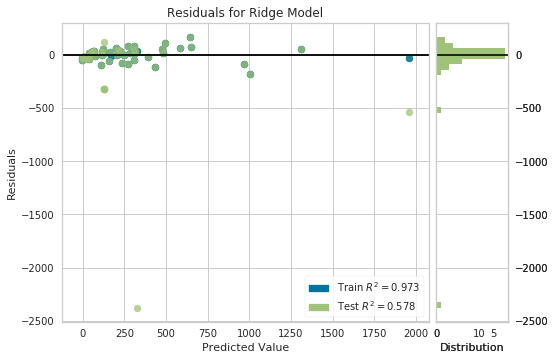

In [0]:
# Calculate predictions
# Initial version of data (v0)
predictLoanCount(dfv0, 'v0')

# Version 6 (after streaming of Iowa data)
displayResiduals(dfv0, dfv6)
predictLoanCount(dfv6, 'v6')

# Version 9 (after correction of data: update, delete, merge)
displayResiduals(dfv0, dfv9)
predictLoanCount(dfv9, 'v9')

#### Review RMSE and Residuals
* Review the RMSE values via the MLflow Sidebar